In [1]:
%matplotlib inline

import eli5
from collections import Counter
import gc
import re
from pathlib import Path
from scipy.sparse import csr_matrix, hstack, vstack
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

from IPython.display import display_html, display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
PATH = Path('../input')
[f.name for f in PATH.iterdir()]

['train_sessions.csv',
 'site_dic.pkl',
 'sample_submission.csv',
 'train.zip',
 'test_sessions.csv']

In [3]:
SEED = 7
sites = [f'site{i}' for i in range(1, 11)]
times = [f'time{i}' for i in range(1, 11)]

In [4]:
train_df = pd.read_csv(PATH/'train_sessions.csv', parse_dates=times, nrows=None)
print(train_df.shape)
train_df.head()

(253561, 22)


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [5]:
test_df = pd.read_csv(PATH/'test_sessions.csv', parse_dates=times, nrows=None)
print(test_df.shape)
test_df.head()

(82797, 21)


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
1,2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
2,3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
3,4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
4,5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [6]:
sites_df = pd.read_pickle(PATH/'site_dic.pkl')
sites_df = {int(v):k.strip() for k, v in sites_df.items()}
sites_df = pd.Series(sites_df).sort_index()
sites_df[0] = 'unknown'
print(sites_df.shape)
sites_df.head()

(48372,)


1    fpdownload2.macromedia.com
2                    hotmail.fr
3                login.live.com
4                 mail.live.com
5          dub122.mail.live.com
dtype: object

In [7]:
train_df[sites] = train_df[sites].astype(np.float32)
test_df[sites] = test_df[sites].astype(np.float32)

In [8]:
train_df['target'].value_counts(normalize=True)

0    0.990941
1    0.009059
Name: target, dtype: float64

In [9]:
# train_df.sort_values(by='time1', inplace=True)
train_df.drop('session_id', axis=1, inplace=True)
# train_df.drop_duplicates(inplace=True)
y_train = train_df.pop('target')
test_sessions = test_df.pop('session_id')

train_df.shape, test_df.shape

((253561, 20), (82797, 20))

In [10]:
logit = LogisticRegression(C=1., solver='liblinear', random_state=SEED)
time_cv_split = TimeSeriesSplit(n_splits=10)
skf_cv_split = StratifiedKFold(n_splits=10)

In [11]:
def cross_val_scheme(model, X_train, y_train, cv_split, site_features, extra_features=None):
    cv_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv_split, n_jobs=-1)
    print(f'CV Scores \n {cv_scores}')
    print(f'Mean cv score: {cv_scores.mean()} \t Std cv score: {cv_scores.std()}')
    model.fit(X_train, y_train)
    
    if extra_features is not None:
        all_features = site_features + extra_features
    else:
        all_features = site_features
    
    display_html(eli5.show_weights(model, feature_names=all_features, top=30))
    if extra_features is not None:
        print(pd.DataFrame({'Feature': extra_features, 'coef': model.coef_.flatten()[-len(extra_features):]}))
        
    return model, cv_scores

In [12]:
def vectorize_sites(train_df, test_df, sites_df, params):
    train_sessions = train_df[sites].fillna(0).astype(np.int32).apply(lambda row: ' '.join([sites_df[site] for site in row]), axis=1)
    test_sessions = test_df[sites].fillna(0).astype(np.int32).apply(lambda row: ' '.join([sites_df[site] for site in row]), axis=1)
    vectorizer = CountVectorizer(**params)
    train_sessions = vectorizer.fit_transform(train_sessions)
    test_sessions = vectorizer.transform(test_sessions)
    
    return vectorizer, train_sessions, test_sessions

In [13]:
%%time

params = {'max_features': 200000, 'ngram_range': (1, 7), 'tokenizer': lambda s: s.split()}
vectorizer, train_data, test_data = vectorize_sites(train_df, test_df, sites_df, params)
site_features = vectorizer.get_feature_names()

CPU times: user 1min 26s, sys: 2.27 s, total: 1min 28s
Wall time: 1min 28s


In [14]:
model1, cv_scores1 = cross_val_scheme(logit, train_data, y_train, skf_cv_split, site_features)

CV Scores 
 [0.96583434 0.9589488  0.96187974 0.96649923 0.96156813 0.9678002
 0.96088505 0.95123503 0.9650012  0.96224861]
Mean cv score: 0.9621900332369775 	 Std cv score: 0.004515903435802564


Weight?,Feature
+4.231,cid-ed6c3e6a5c6608a4.users.storage.live.com
+2.888,cid-4390f92c7906cc9c.users.storage.live.com
+2.865,www.monalbumphoto.fr
+2.681,www.activistpost.com
+2.491,browser-update.org
+2.280,braindamaged.fr
+2.186,www.express.co.uk
+2.178,tru.am
+2.120,mcetv.fr
+2.112,www.video.tt


In [15]:
top_alice_sites = pd.Series(train_df.loc[y_train == 1, sites].values.flatten()).value_counts(ascending=False)
top_alice_sites = pd.Series(top_alice_sites.index.values, index=top_alice_sites).head(20).reset_index(drop=True) #transpose
top_alice_sites.head()

0    77.0
1    80.0
2    76.0
3    29.0
4    21.0
dtype: float64

In [16]:
train_num_alice_sites = train_df[sites].apply(
    lambda sites: len(set([site for site, c in Counter(sites.values).items() if site in top_alice_sites.values])) > 0, axis=1)
# train_avg_alice_sites = train_num_alice_sites / train_nunique_sites
# test_avg_alice_sites = test_num_alice_sites / test_nunique_sites

test_num_alice_sites = test_df[sites].apply(
    lambda sites: len(set([site for site, c in Counter(sites.values).items() if site in top_alice_sites.values])) > 0, axis=1)

In [17]:
# f, ax = plt.subplots(1, 2, figsize=(12, 6))
# train_num_alice_sites[y_train == 0].hist(ax=ax[0])
# train_num_alice_sites[y_train == 1].hist(ax=ax[1]);

In [18]:
%%time

train_data2 = hstack([train_data, train_num_alice_sites.values.reshape(-1, 1)]).tocsr()
test_data2 = hstack([test_data, test_num_alice_sites.values.reshape(-1, 1)]).tocsr()
model2, cv_scores2 = cross_val_scheme(logit, train_data2, y_train, skf_cv_split, site_features, extra_features=['num_alice_sites'])

CV Scores 
 [0.96565543 0.95898808 0.96193978 0.96799874 0.96158007 0.967831
 0.96088401 0.95128856 0.96482358 0.96225695]
Mean cv score: 0.9623246203980698 	 Std cv score: 0.004642891194880382


Weight?,Feature
+4.238,cid-ed6c3e6a5c6608a4.users.storage.live.com
+2.889,cid-4390f92c7906cc9c.users.storage.live.com
+2.863,www.monalbumphoto.fr
+2.680,www.activistpost.com
+2.493,browser-update.org
+2.289,braindamaged.fr
+2.185,www.express.co.uk
+2.181,tru.am
+2.115,mcetv.fr
+2.113,www.video.tt


           Feature      coef
0  num_alice_sites  0.121143
CPU times: user 30.5 s, sys: 268 ms, total: 30.8 s
Wall time: 2min 42s


In [19]:
cv_scores2 > cv_scores1

array([False,  True,  True,  True,  True,  True, False,  True, False,
        True])

In [20]:
train_duration = np.log1p((train_df[times].max(axis=1) - train_df[times].min(axis=1)).dt.seconds)
test_duration = np.log1p((test_df[times].max(axis=1) - test_df[times].min(axis=1)).dt.seconds)
# du_scaler = MinMaxScaler()
# train_duration = du_scaler.fit_transform(train_duration.values.reshape(-1, 1)).reshape(-1)
# test_duration = du_scaler.transform(test_duration.values.reshape(-1, 1)).reshape(-1)

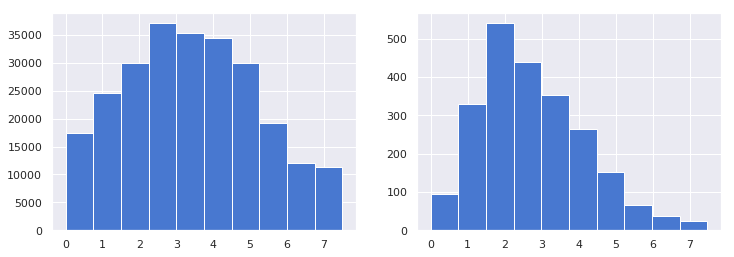

In [21]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(train_duration[y_train == 0])
ax[1].hist(train_duration[y_train == 1]);

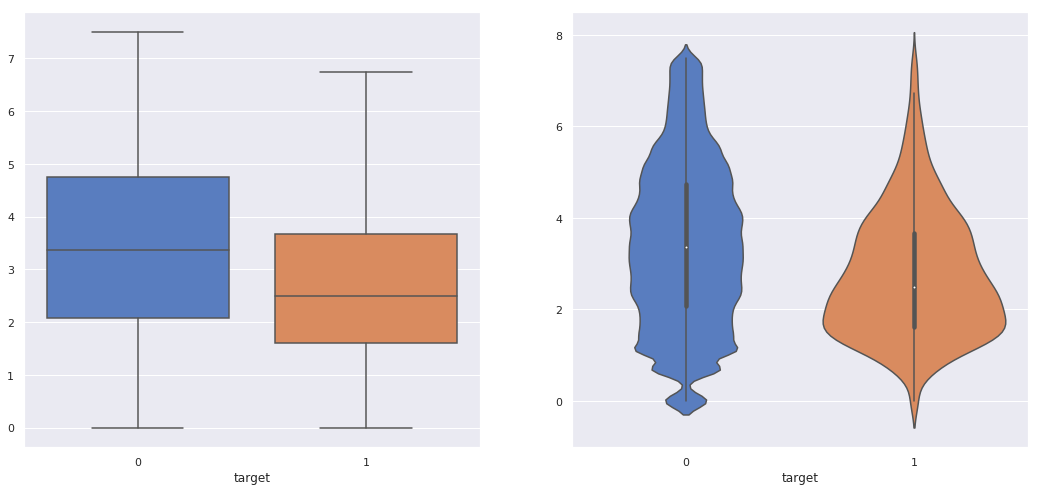

In [22]:
_, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.boxplot(y_train, train_duration, showfliers=False, ax=ax[0])
sns.violinplot(y_train, train_duration, showfliers=False, ax=ax[1]);

In [23]:
%%time
"""
CV Scores 
 [0.96614918 0.95913005 0.96224337 0.96784457 0.96172915 0.96819768
 0.96070016 0.9518368  0.96458635 0.96234011]
Mean cv score: 0.9624757408959341 	 Std cv score: 0.004557156146639378
"""

train_data3 = hstack([train_data2, train_duration.values.reshape(-1, 1)]).tocsr()
test_data3 = hstack([test_data2, test_duration.values.reshape(-1, 1)]).tocsr()
model3, cv_scores3 = cross_val_scheme(logit, train_data3, y_train, skf_cv_split, site_features, extra_features=['num_alice_sites', 'duration'])

CV Scores 
 [0.96614918 0.95913005 0.96224337 0.96784457 0.96172915 0.96819768
 0.96070016 0.9518368  0.96458635 0.96234011]
Mean cv score: 0.9624757408959341 	 Std cv score: 0.004557156146639378


Weight?,Feature
+4.211,cid-ed6c3e6a5c6608a4.users.storage.live.com
+2.874,cid-4390f92c7906cc9c.users.storage.live.com
+2.855,www.monalbumphoto.fr
+2.671,www.activistpost.com
+2.478,browser-update.org
+2.292,braindamaged.fr
+2.193,www.express.co.uk
+2.183,tru.am
+2.154,www.video.tt
+2.150,mcetv.fr


           Feature      coef
0  num_alice_sites  0.123567
1         duration -0.093777
CPU times: user 47.5 s, sys: 224 ms, total: 47.7 s
Wall time: 3min 7s


In [24]:
cv_scores3 > cv_scores2

array([ True,  True,  True, False,  True,  True, False,  True, False,
        True])

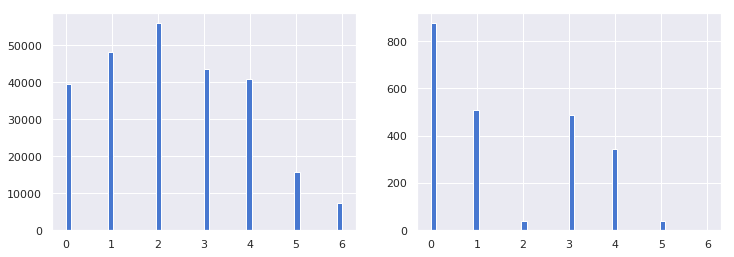

In [25]:
trn_hour = train_df['time1'].dt.weekday
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(trn_hour[y_train == 0], bins=52)
ax[1].hist(trn_hour[y_train == 1], bins=52);

In [26]:
def add_time_features(df):
    tmp_df = pd.DataFrame()
    cat_feats = []
    
    tmp_df['start_month'] = df['time1'].dt.month
    cat_feats.append('start_month')
    
#     tmp_df['start_year'] = df['time1'].dt.year
    
    tmp_df['year_month'] = 12*(df['time1'].dt.year - 2013) + df['time1'].dt.month
    cat_feats.append('year_month')
    
    tmp_df['start_weekday'] = df['time1'].dt.dayofweek
    cat_feats.append('start_weekday')
    
    tmp_df['start_weekend'] = (tmp_df['start_weekday'] > 4).astype(np.int32)

    tmp_df['start_hour'] = df['time1'].dt.hour
    cat_feats.append('start_hour')
    
    # Alice is mostly active
    tmp_df['active1213'] = df['time1'].apply(lambda t: 12 <= t.hour <= 13).astype(np.int32)
    tmp_df['active1618'] = df['time1'].apply(lambda t: 16 <= t.hour <= 18).astype(np.int32)
#     tmp_df['hour915'] = df['time1'].apply(lambda x: (x.hour == 9 or x.hour == 15)).astype('int')
    
    # Alice not active
    tmp_df['active0911'] = df['time1'].apply(lambda t: 9 <= t.hour <= 11).astype(np.int32)
    
#     tmp_df['start_minute'] = df['time1'].dt.minute
#     tmp_df['minutespent'] = (df['time1'].dt.hour * 60) + df['time1'].dt.minute
    
#     tmp_df['morning'] = ((df['time1'].dt.hour >= 0) & (df['time1'].dt.hour <= 5)).astype(np.int32)
    
#     tmp_df['day'] = ((df['time1'].dt.hour >= 6) & (df['time1'].dt.hour <= 11)).astype(np.int32)
    
    tmp_df['evening'] = ((df['time1'].dt.hour >= 12) & (df['time1'].dt.hour <= 17)).astype(np.int32)
    
    tmp_df['night'] = ((df['time1'].dt.hour >= 17) & (df['time1'].dt.hour <= 23)).astype(np.int32)

#     tmp_df['is_quarter_end'] = df['time1'].dt.is_quarter_end.astype(np.int32)
    
    return tmp_df, cat_feats

In [27]:
train_time_data, cat_feats = add_time_features(train_df)

In [28]:
test_time_data, _ = add_time_features(test_df)

In [29]:
train_time_data.tail()

,start_month,year_month,start_weekday,start_weekend,start_hour,active1213,active1618,active0911,evening,night
253556,11,11,0,0,10,0,0,1,0,0
253557,3,3,1,0,16,0,1,0,1,0
253558,9,9,3,0,14,0,0,0,1,0
253559,12,12,3,0,15,0,0,0,1,0
253560,4,16,4,0,9,0,0,1,0,0


In [30]:
train_split = train_time_data.shape[0]
full_time_data = pd.get_dummies(pd.concat((train_time_data, test_time_data)), columns=cat_feats, drop_first=True)
train_oh_data = full_time_data[:train_split]
test_oh_data = full_time_data[train_split:]

In [31]:
%%time
"""
CV Scores 
 [0.99174143 0.98828387 0.9911879  0.99239256 0.9836241  0.99495863
 0.98923772 0.98550502 0.99181001 0.9897467 ]
Mean cv score: 0.9898487927573735 	 Std cv score: 0.003197667813220081
"""

extra_feats = ['alice_sites', 'duration'] + list(train_oh_data.columns)

train_data4 = hstack([train_data3, train_oh_data]).tocsr()
test_data4 = hstack([test_data3, test_oh_data]).tocsr()
model4, cv_scores4 = cross_val_scheme(logit, train_data4, y_train, skf_cv_split, site_features, extra_features=extra_feats)

CV Scores 
 [0.99179871 0.98836156 0.9912578  0.99240588 0.98331488 0.99497091
 0.98930538 0.98562025 0.99183052 0.98971681]
Mean cv score: 0.9898582686372622 	 Std cv score: 0.0032493981023075788


Weight?,Feature
+4.066,cid-ed6c3e6a5c6608a4.users.storage.live.com
+2.986,www.activistpost.com
+2.536,active1618
+2.503,tru.am
+2.461,www.express.co.uk
+2.352,www.neatorama.com
+2.248,www.billetreduc.com
+2.213,www.video.tt
+2.132,mcetv.fr
+2.104,cid-4390f92c7906cc9c.users.storage.live.com


            Feature      coef
0       alice_sites  0.222011
1          duration -0.194244
2     start_weekend -1.487427
3        active1213  1.128210
4        active1618  2.535756
5        active0911 -1.960269
6           evening  0.062462
7             night -0.464680
8     start_month_2 -0.209489
9     start_month_3 -1.257096
10    start_month_4  0.303526
11    start_month_5 -0.631896
12    start_month_6 -0.376941
13    start_month_7 -0.012543
14    start_month_8 -0.557162
15    start_month_9  1.818680
16   start_month_10 -1.380671
17   start_month_11  0.254956
18   start_month_12  0.003918
19     year_month_2  0.012817
20     year_month_3 -1.568639
21     year_month_4  0.985872
22     year_month_5 -0.631896
23     year_month_6 -0.376941
24     year_month_7 -0.012543
25     year_month_8 -0.557162
26     year_month_9  1.818680
27    year_month_10 -1.380671
28    year_month_11  0.254956
29    year_month_12  0.003918
..              ...       ...
34    year_month_17  0.000000
35    year

In [32]:
def create_submission(test_preds, session_ids, name='submission'):
    df = pd.DataFrame({'session_id': session_ids, 'target': test_preds})
    df.to_csv(f'{name}.csv', header=True, index=False)
    return df

In [33]:
logit.fit(train_data4, y_train)
test_preds = logit.predict_proba(test_data4)[:, 1]
test_sub = create_submission(test_preds, test_sessions)